# **Import Modules**

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import warnings
import re
import string
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Embedding, LSTM, Dense, Dropout,
                                     GlobalMaxPooling1D, Conv1D, GRU,
                                     Bidirectional, BatchNormalization,
                                     SpatialDropout1D, MaxPooling1D,
                                     Activation, GlobalAveragePooling1D,
                                     Input, Concatenate)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight

warnings.filterwarnings('ignore')

In [2]:

RANDOM_STATE = 42
MAX_FEATURES = 20000
MAX_LEN = 100
EMBEDDING_DIM = 200
BATCH_SIZE = 64
EPOCHS = 20

# **Load Data**

In [3]:
!wget --no-check-certificate https://raw.githubusercontent.com/rioooranteai/nlp-project/main/Analisis%20Sentimen%20-%20Coretax/Dataset/Prep_Version-2/With-Lemma/Dataset_roberta.csv -O "/content/Dataset.csv"

--2025-05-07 07:17:34--  https://raw.githubusercontent.com/rioooranteai/nlp-project/main/Analisis%20Sentimen%20-%20Coretax/Dataset/Prep_Version-2/With-Lemma/Dataset_roberta.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1892065 (1.8M) [text/plain]
Saving to: ‘/content/Dataset.csv’

/content/Dataset.cs 100%[===================>]   1.80M  --.-KB/s    in 0.05s   

2025-05-07 07:17:35 (38.4 MB/s) - ‘/content/Dataset.csv’ saved [1892065/1892065]



In [4]:
df = pd.read_csv("/content/Dataset.csv", usecols=['full_text', 'sentiment'])
df.head()

,full_text,sentiment
0,hai kak. mohon maaf atas tidaknyama nya . apab...,neutral
1,hai kak. mohon maaf atas tidaknyama nya . munc...,neutral
2,hai kak . alamat kakak pindah wilayah kerja kp...,neutral
3,hhaaai! sha open jasa ges *lapor spt masa pph ...,neutral
4,pajak bayar lewat sakti 3.480.390 aplikasi cor...,neutral


In [5]:
df.tail()

,full_text,sentiment
14692,gw curiga server sakti dipake buat coretax jug...,negative
14693,kak hari ( kringpajak ) coba buka dulu coretax...,neutral
14694,kayak pernah denger coretax deh. . . ( ngga as...,negative
14695,setuju sangat setuju! individu bayar pajak san...,negative
14696,sering dapet kinini data kak coretax,neutral


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14697 entries, 0 to 14696
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   full_text  14695 non-null  object
 1   sentiment  14697 non-null  object
dtypes: object(2)
memory usage: 229.8+ KB


In [7]:
df['full_text'] = df['full_text'].str.strip()

# **Preprocessing**

In [8]:
def preprocessing(text):
    if isinstance(text, str):
        text = text.lower()
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        text = re.sub(r'@\w+', '', text)
        text = re.sub(r'#(\w+)', r'\1', text)
        text = re.sub(r'[^\w\s\d]', '', text)
        text = re.sub(r'rp\.?\s*(\d+[\d\.,]*)', r'rupiah \1', text)
        text = re.sub(r'(\d+)jt', r'\1 juta', text)
        text = re.sub(r'(\d+)M', r'\1 juta', text)
        text = re.sub(r'(\d+)rb', r'\1 ribu', text)
        text = re.sub(r'(\d+)[%٪]', r'\1 persen', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text
    else:
        return ""

df['full_text'] = df['full_text'].apply(preprocessing)

# **Split Data**

In [9]:
data = df.copy(deep=True)
data.dropna(inplace=True)

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14697 entries, 0 to 14696
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   full_text  14697 non-null  object
 1   sentiment  14697 non-null  object
dtypes: object(2)
memory usage: 229.8+ KB


In [11]:
le = LabelEncoder()

data['sentiment'] = le.fit_transform(data['sentiment'])

In [12]:
X = data['full_text']
y = tf.keras.utils.to_categorical(data['sentiment'], num_classes=3)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

# **Tokenization**

In [14]:
tokenizer = Tokenizer(num_words=MAX_FEATURES, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding='post', truncating='post')

In [15]:
print(f"Shape X_train: {X_train_pad.shape}")
print(f"Shape y_train: {y_train.shape}")
print(f"Shape X_test: {X_test_pad.shape}")
print(f"Shape y_test: {y_test.shape}")

Shape X_train: (11757, 100)
Shape y_train: (11757, 3)
Shape X_test: (2940, 100)
Shape y_test: (2940, 3)


# **Training Models**

In [16]:
class_weights = compute_class_weight('balanced', classes=np.unique(np.argmax(y_train, axis=1)), y=np.argmax(y_train, axis=1))

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

class MyCallBack(tf.keras.callbacks.Callback):
      def __init__(self, acc_threshold=0.92):
          super().__init__()
          self.acc_threshold = acc_threshold

      def on_epoch_end(self, epoch, logs=None):
          logs = logs or {}
          acc = logs.get("accuracy")
          val_acc = logs.get("val_accuracy")

          if acc is not None and val_acc is not None:
              if acc >= self.acc_threshold and val_acc >= self.acc_threshold:
                  print(f"\n✅ Akurasi dan Val_akurasi ≥ {self.acc_threshold*100:.0f}%. Training dihentikan.")
                  self.model.stop_training = True

my_callback = MyCallBack(acc_threshold=0.92)

## **Gated Recurrent Unit (GRU)**

### Train Model

In [17]:
gru_model = Sequential([
    Embedding(MAX_FEATURES, EMBEDDING_DIM, input_length=MAX_LEN),
    SpatialDropout1D(0.2),
    Bidirectional(GRU(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.3)),
    Bidirectional(GRU(128, dropout=0.3, recurrent_dropout=0.3)),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

gru_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

In [18]:
gru_checkpoint = ModelCheckpoint('gru_model.h5', monitor='val_accuracy', save_best_only=True)

gru_history = gru_model.fit(
      X_train_pad, y_train,
      epochs=EPOCHS,
      batch_size=BATCH_SIZE,
      validation_split=0.1,
      callbacks=[early_stopping, gru_checkpoint, my_callback],
      verbose=1
)

Epoch 1/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6929 - loss: 0.7085

166/166 ━━━━━━━━━━━━━━━━━━━━ 191s 1s/step - accuracy: 0.6933 - loss: 0.7078 - val_accuracy: 0.8172 - val_loss: 0.4741
Epoch 2/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8670 - loss: 0.3861

166/166 ━━━━━━━━━━━━━━━━━━━━ 197s 1s/step - accuracy: 0.8670 - loss: 0.3861 - val_accuracy: 0.8384 - val_loss: 0.4070
Epoch 3/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 200s 1s/step - accuracy: 0.9207 - loss: 0.2319 - val_accuracy: 0.8240 - val_loss: 0.4927
Epoch 4/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - accuracy: 0.9459 - loss: 0.1587 - val_accuracy: 0.8214 - val_loss: 0.5272
Epoch 5/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - accuracy: 0.9641 - loss: 0.1090 - val_accuracy: 0.8248 - val_loss: 0.6394
Epoch 6/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - accuracy: 0.9724 - loss: 0.0842 - val_accuracy: 0.8189 - val_loss: 0.7175
Epoch 7/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - accuracy: 0.9790 - loss: 0.0695 - val_accuracy: 0.8053 - val_loss: 0.6797


### Evaluation

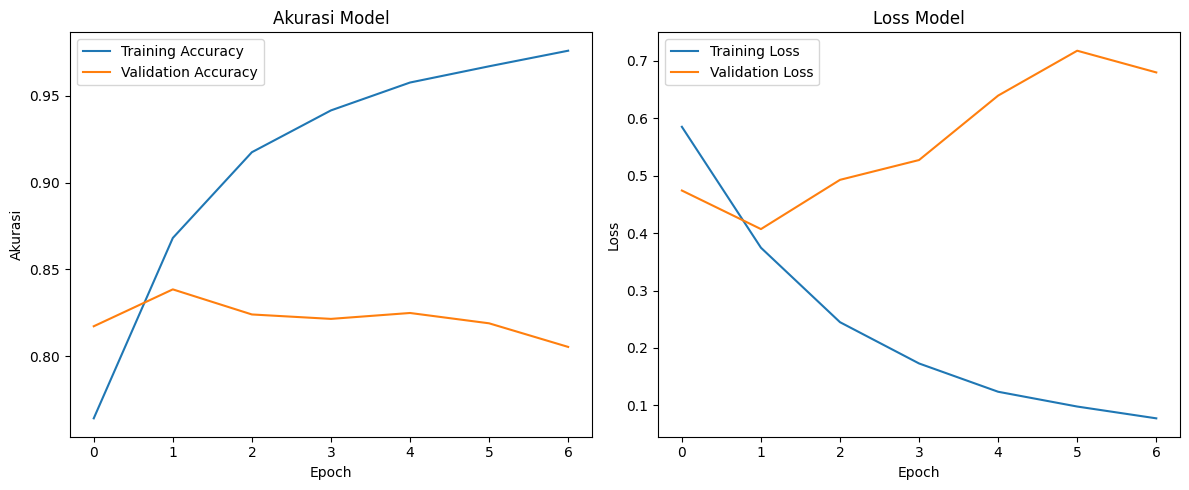

In [19]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(gru_history.history['accuracy'], label='Training Accuracy')
plt.plot(gru_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Akurasi Model')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(gru_history.history['loss'], label='Training Loss')
plt.plot(gru_history.history['val_loss'], label='Validation Loss')
plt.title('Loss Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [20]:
gru_model = tf.keras.models.load_model('gru_model.h5')
gru_preds = gru_model.predict(X_test_pad)

y_pred = np.argmax(gru_preds, axis=1)
y_true = np.argmax(y_test, axis=1)

print("📊 GRU Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=le.classes_))

92/92 ━━━━━━━━━━━━━━━━━━━━ 21s 210ms/step
📊 GRU Classification Report:

              precision    recall  f1-score   support

    negative       0.82      0.87      0.84      1245
     neutral       0.90      0.88      0.89      1519
    positive       0.49      0.39      0.43       176

    accuracy                           0.85      2940
   macro avg       0.74      0.71      0.72      2940
weighted avg       0.84      0.85      0.84      2940



### Inference

In [22]:
print(f"Teks Asli : {X_test.iloc[10]}")
print(f"Label Asli : {le.classes_[np.argmax(y_test[10])]}")

gru_preds = gru_model.predict(X_test_pad[[10]])

y_pred = np.argmax(gru_preds, axis=1)
print(f"Label Prediksi : {le.classes_[y_pred]}")

Teks Asli : hai kak dapat ubah isi data coretax pastikan seluruh kolom tanda bintang sudh terisi kak kendala tsb mohon pastikan seluruh data bagi informasi umum terisi silakan kakak klik ambil data baru dg ahu
Label Asli : neutral
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step
Label Prediksi : ['neutral']


## **LSTM**

### Train Model

In [23]:
lstm_model = Sequential([
    Embedding(MAX_FEATURES, EMBEDDING_DIM, input_length=MAX_LEN),
    SpatialDropout1D(0.2),
    Bidirectional(LSTM(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.3)),
    Bidirectional(LSTM(128, dropout=0.3, recurrent_dropout=0.3)),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

lstm_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

In [24]:
lstm_checkpoint = ModelCheckpoint('lstm_model.h5', monitor='val_accuracy', save_best_only=True)

In [25]:
lstm_history = lstm_model.fit(
            X_train_pad, y_train,
            epochs=EPOCHS,
            batch_size=BATCH_SIZE,
            validation_split=0.1,
            callbacks=[early_stopping, lstm_checkpoint, my_callback],
            verbose=1
)

Epoch 1/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6639 - loss: 0.7341

166/166 ━━━━━━━━━━━━━━━━━━━━ 226s 1s/step - accuracy: 0.6645 - loss: 0.7333 - val_accuracy: 0.8359 - val_loss: 0.4517
Epoch 2/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8571 - loss: 0.4032

166/166 ━━━━━━━━━━━━━━━━━━━━ 241s 1s/step - accuracy: 0.8571 - loss: 0.4031 - val_accuracy: 0.8401 - val_loss: 0.4936
Epoch 3/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - accuracy: 0.8965 - loss: 0.2832 - val_accuracy: 0.8257 - val_loss: 0.4523
Epoch 4/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 204s 1s/step - accuracy: 0.9377 - loss: 0.1853 - val_accuracy: 0.8172 - val_loss: 0.5627
Epoch 5/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 200s 1s/step - accuracy: 0.9515 - loss: 0.1453 - val_accuracy: 0.8223 - val_loss: 0.6710
Epoch 6/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - accuracy: 0.9677 - loss: 0.1015 - val_accuracy: 0.8129 - val_loss: 0.6111
Epoch 7/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 204s 1s/step - accuracy: 0.9744 - loss: 0.0914 - val_accuracy: 0.8274 - val_loss: 0.6543


### Evaluation

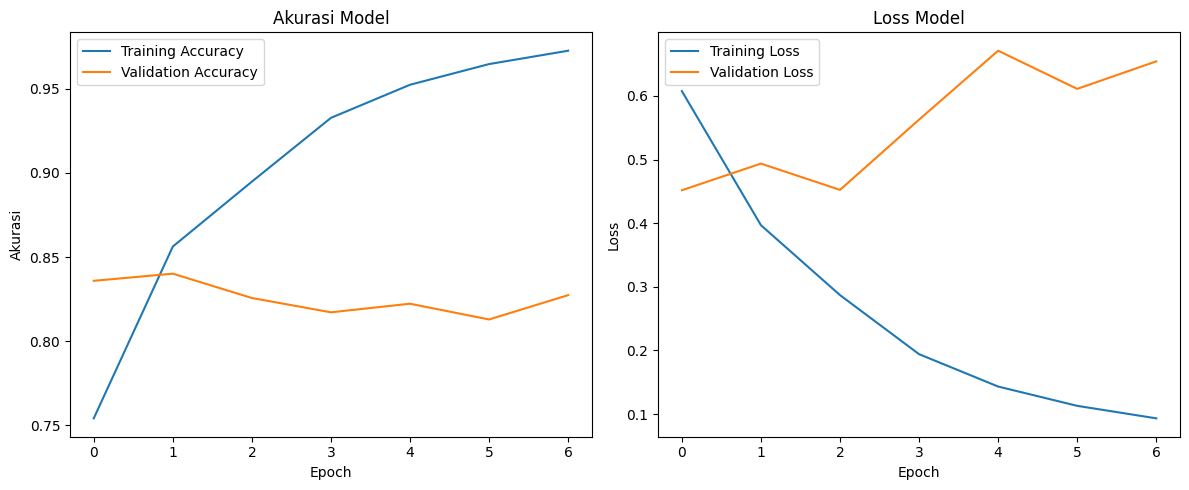

In [26]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(lstm_history.history['accuracy'], label='Training Accuracy')
plt.plot(lstm_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Akurasi Model')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(lstm_history.history['loss'], label='Training Loss')
plt.plot(lstm_history.history['val_loss'], label='Validation Loss')
plt.title('Loss Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [30]:
lstm_model = tf.keras.models.load_model('lstm_model.h5')
lstm_preds = lstm_model.predict(X_test_pad)

y_pred = np.argmax(lstm_preds, axis=1)
y_true = np.argmax(y_test, axis=1)

print("📊 LSTM Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=le.classes_))

92/92 ━━━━━━━━━━━━━━━━━━━━ 22s 218ms/step
📊 LSTM Classification Report:

              precision    recall  f1-score   support

    negative       0.79      0.88      0.83      1245
     neutral       0.88      0.90      0.89      1519
    positive       0.67      0.01      0.02       176

    accuracy                           0.84      2940
   macro avg       0.78      0.60      0.58      2940
weighted avg       0.83      0.84      0.81      2940



### Inference

In [28]:
print(f"Teks Asli : {X_test.iloc[10]}")
print(f"Label Asli : {le.classes_[np.argmax(y_test[10])]}")

lstm_preds = lstm_model.predict(X_test_pad[[10]])

y_pred = np.argmax(lstm_preds, axis=1)
print(f"Label Prediksi : {le.classes_[y_pred]}")

Teks Asli : hai kak dapat ubah isi data coretax pastikan seluruh kolom tanda bintang sudh terisi kak kendala tsb mohon pastikan seluruh data bagi informasi umum terisi silakan kakak klik ambil data baru dg ahu
Label Asli : neutral
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Label Prediksi : ['neutral']


## **Convolutional Neural Network (CNN)**

### Train Model

In [32]:
inputs = Input(shape=(MAX_LEN,))
embedding = Embedding(MAX_FEATURES, EMBEDDING_DIM, input_length=MAX_LEN)(inputs)

conv1 = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(embedding) # Add padding='same'
pool1 = MaxPooling1D(pool_size=2)(conv1)

conv2 = Conv1D(filters=128, kernel_size=4, activation='relu', padding='same')(embedding) # Add padding='same'
pool2 = MaxPooling1D(pool_size=2)(conv2)

conv3 = Conv1D(filters=128, kernel_size=5, activation='relu', padding='same')(embedding) # Add padding='same'
pool3 = MaxPooling1D(pool_size=2)(conv3)

concat = Concatenate()([pool1, pool2, pool3])
flat = GlobalAveragePooling1D()(concat)

dense1 = Dense(128, activation='relu')(flat)
drop = Dropout(0.5)(dense1)
outputs = Dense(3, activation='softmax')(drop)

cnn_model = Model(inputs=inputs, outputs=outputs)

cnn_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

In [33]:
cnn_checkpoint = ModelCheckpoint('cnn_model.h5', monitor='val_accuracy', save_best_only=True)

cnn_history = cnn_model.fit(
            X_train_pad, y_train,
            epochs=EPOCHS,
            batch_size=BATCH_SIZE,
            validation_split=0.1,
            callbacks=[early_stopping, cnn_checkpoint, my_callback],
            verbose=1
)

Epoch 1/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6405 - loss: 0.7507

166/166 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.6411 - loss: 0.7499 - val_accuracy: 0.8333 - val_loss: 0.4371
Epoch 2/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8505 - loss: 0.4135 - val_accuracy: 0.8308 - val_loss: 0.4351
Epoch 3/20
160/166 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8963 - loss: 0.2905

166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8963 - loss: 0.2904 - val_accuracy: 0.8359 - val_loss: 0.4842
Epoch 4/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9276 - loss: 0.2010 - val_accuracy: 0.8248 - val_loss: 0.5572
Epoch 5/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9550 - loss: 0.1406 - val_accuracy: 0.8231 - val_loss: 0.6533
Epoch 6/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9756 - loss: 0.0833 - val_accuracy: 0.8172 - val_loss: 0.7333
Epoch 7/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9793 - loss: 0.0663 - val_accuracy: 0.8163 - val_loss: 0.8173
Epoch 8/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9862 - loss: 0.0446 - val_accuracy: 0.8129 - val_loss: 0.8539


### Evaluation

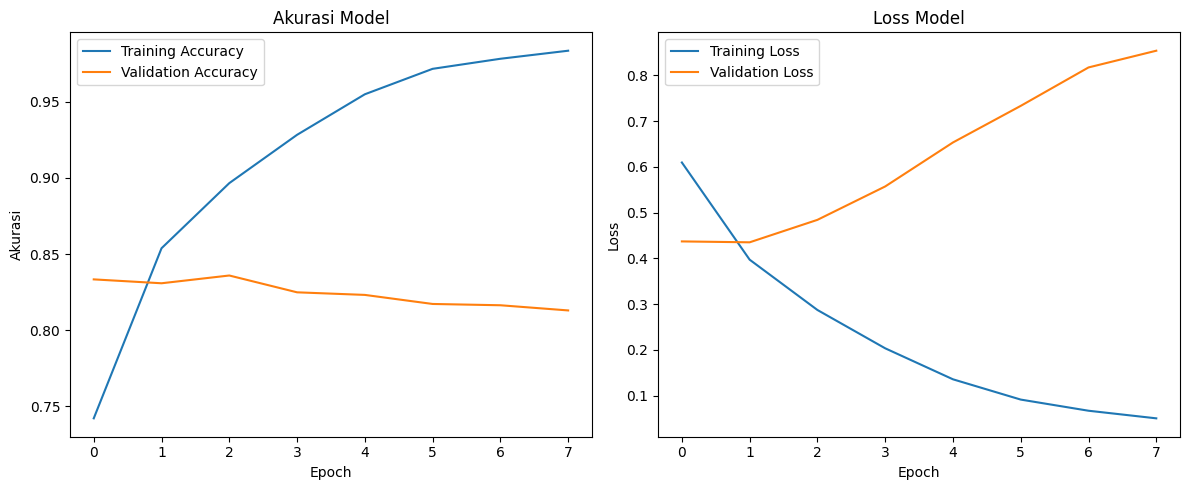

In [34]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(cnn_history.history['accuracy'], label='Training Accuracy')
plt.plot(cnn_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Akurasi Model')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(cnn_history.history['loss'], label='Training Loss')
plt.plot(cnn_history.history['val_loss'], label='Validation Loss')
plt.title('Loss Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [35]:
cnn_model = tf.keras.models.load_model('cnn_model.h5')
cnn_preds = cnn_model.predict(X_test_pad)

y_pred = np.argmax(cnn_preds, axis=1)
y_true = np.argmax(y_test, axis=1)

print("📊 CNN Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=le.classes_))

92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
📊 CNN Classification Report:

              precision    recall  f1-score   support

    negative       0.82      0.86      0.84      1245
     neutral       0.89      0.89      0.89      1519
    positive       0.48      0.28      0.35       176

    accuracy                           0.84      2940
   macro avg       0.73      0.68      0.69      2940
weighted avg       0.83      0.84      0.84      2940



### Inference

In [37]:
print(f"Teks Asli : {X_test.iloc[10]}")
print(f"Label Asli : {le.classes_[np.argmax(y_test[10])]}")

cnn_preds = cnn_model.predict(X_test_pad[[10]])

y_pred = np.argmax(cnn_preds, axis=1)
print(f"Label Prediksi : {le.classes_[y_pred]}")

Teks Asli : hai kak dapat ubah isi data coretax pastikan seluruh kolom tanda bintang sudh terisi kak kendala tsb mohon pastikan seluruh data bagi informasi umum terisi silakan kakak klik ambil data baru dg ahu
Label Asli : neutral
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Label Prediksi : ['neutral']
